<h2>Imports</h2>

In [1]:
import math
import random
import os
from common.multiprocessing_env import SubprocVecEnv

import gym
import my_envs
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

from IPython.display import clear_output, display
import matplotlib.pyplot as plt
%matplotlib inline

<h2>Use CUDA</h2>

In [2]:
use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

<h2>Create Environments</h2>

In [3]:
def make_env():
    def _thunk():
        env = gym.make(env_name)
        return env

    return _thunk

In [4]:
def testing_envs(env_name, VISUALIZE, logging_interval = 10):
    logdir = ("./" + env_name + "_videos/")
    env = gym.make(env_name)
    if VISUALIZE:
        if not os.path.exists(logdir):
            os.mkdir(logdir)
            env = gym.wrappers.Monitor(env, logdir, force=True, video_callable=lambda episode_id: episode_id%logging_interval==0)
    return env

def make_env(env_name):
    def _thunk():
        env = gym.make(env_name)
        return env
    return _thunk

In [5]:
from gym import envs

VISUALIZE = False
EARLY_STOPPING = True
logging_interval = 10
num_envs = 4
env_key = "InvertedPendulum-v2" #Unique identifier for custom envs (case sensitive)

env_name = 'InvertedPendulum-v2'
#env_name = "Pendulum-v0"
#env_name = "HalfCheetah-v2"
#env_name = 'FetchReach-v1'

env_ids = [spec.id for spec in envs.registry.all()]
test_env_names = [env_name] + [x for x in env_ids if str(env_key) in x] #Returns a list of environment names matching identifier

#Training envs (all the same)
envs = [make_env(env_name) for i in range(num_envs)]
envs = SubprocVecEnv(envs)

#Testing on original and new envs
test_envs = [testing_envs(env_name, VISUALIZE, logging_interval) for env_name in test_env_names]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.

<h2>Not used functions</h2>

In [6]:
#Tried for rendering in notebook
def show_state(env, step=0):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    #plt.title("%s. Step: %d" % (env._spec.id,step))
    
    plt.pause(0.001)  # pause for plots to update

    if 0:
        display.clear_output(wait=True)
        display.display(plt.gcf())
        
        
#I was using to unwrap the fetch-reach environment
def to_obs(states):
    if isinstance(states, dict):
        obs = np.hstack(states.values())[0:10]
    else:
        obs = []
        for state in states:
            obs.append(np.hstack(state.values())[0:10])
        obs = np.vstack(obs)
    return obs

<h2>Neural Network</h2>

In [7]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0., std=0.1)
        nn.init.constant_(m.bias, 0.1)
        

class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_size, std=0.0):
        super(ActorCritic, self).__init__()
        
        self.critic = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        
        self.actor = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_outputs),
        )
        self.log_std = nn.Parameter(torch.ones(1, num_outputs) * std)
        
        self.apply(init_weights)
        
    def forward(self, x):
        value = self.critic(x)
        mu    = self.actor(x)
        std   = self.log_std.exp().expand_as(mu)
        dist  = Normal(mu, std)
        return dist, value

In [8]:
def plot(frame_idx, rewards, stds, test_envs):
    clear_output(True)
    num_plots = len(rewards[0])
    x = range(1,len(rewards)+1)
    rewards = np.array(rewards) #v-stacks the rewards, each env of rewards is thus a column
    stds = np.array(stds) #v-stacks the standard deviations, each env of standard deviation is thus a column
    rew_high = rewards + stds
    rew_low = rewards - stds
    
    plt.figure(figsize=(20,8*num_plots))
    
    for i in range(1,1+num_plots):
        plt.subplot(num_plots, 1, i)
        plt.title('env: %s frame %s. reward: %s' % (test_envs[i-1], frame_idx, rewards[-1,i-1]))
        plt.plot(x, rewards[:,i-1],
                 x, rew_high[:,i-1],
                 x, rew_low[:,i-1], color='b',linewidth=2.5)

        plt.fill_between(x, rew_high[:,i-1], rew_low[:,i-1], color='b', alpha=0.5)
    plt.show()
    
def test_env(test_env, vis=False):
    state = test_env.reset()
    if vis: test_env.render()
    done = False
    total_reward = 0
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        dist, _ = model(state)
        next_state, reward, done, _ = test_env.step(dist.sample().cpu().numpy()[0])
        state = next_state
        if vis: test_env.render()
        total_reward += reward
    return total_reward

<h2>GAE</h2>

In [9]:
def compute_gae(next_value, rewards, masks, values, gamma=0.99, tau=0.95):
    values = values + [next_value]
    gae = 0
    returns = []
    for step in reversed(range(len(rewards))):
        delta = rewards[step] + gamma * values[step + 1] * masks[step] - values[step]
        gae = delta + gamma * tau * masks[step] * gae
        returns.insert(0, gae + values[step])
    return returns

<h1> Proximal Policy Optimization Algorithm</h1>
<h2><a href="https://arxiv.org/abs/1707.06347">Arxiv</a></h2>

In [10]:
def ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantage):
    batch_size = states.size(0)
    for _ in range(batch_size // mini_batch_size):
        rand_ids = np.random.randint(0, batch_size, mini_batch_size)
        yield states[rand_ids, :], actions[rand_ids, :], log_probs[rand_ids, :], returns[rand_ids, :], advantage[rand_ids, :]
        
        

def ppo_update(ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantages, clip_param=0.2):
    for _ in range(ppo_epochs):
        for state, action, old_log_probs, return_, advantage in ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantages):
            dist, value = model(state)
            entropy = dist.entropy().mean()
            new_log_probs = dist.log_prob(action)

            ratio = (new_log_probs - old_log_probs).exp()
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1.0 - clip_param, 1.0 + clip_param) * advantage

            actor_loss  = - torch.min(surr1, surr2).mean()
            critic_loss = (return_ - value).pow(2).mean()

            loss = 0.5 * critic_loss + actor_loss - 0.001 * entropy

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [11]:
num_inputs  = envs.observation_space.shape[0]
num_outputs = envs.action_space.shape[0]

#Hyper params:
hidden_size      = 64
lr               = 3e-4
num_steps        = 2048
mini_batch_size  = 64
ppo_epochs       = 10
#threshold_reward = 49
threshold_reward = 900
#threshold_reward = -100
#threshold_reward = 3000


model = ActorCritic(num_inputs, num_outputs, hidden_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [12]:
max_frames = 1000000
frame_idx  = 0
test_avg_rewards = []
test_stds = []
test_itrs = 100

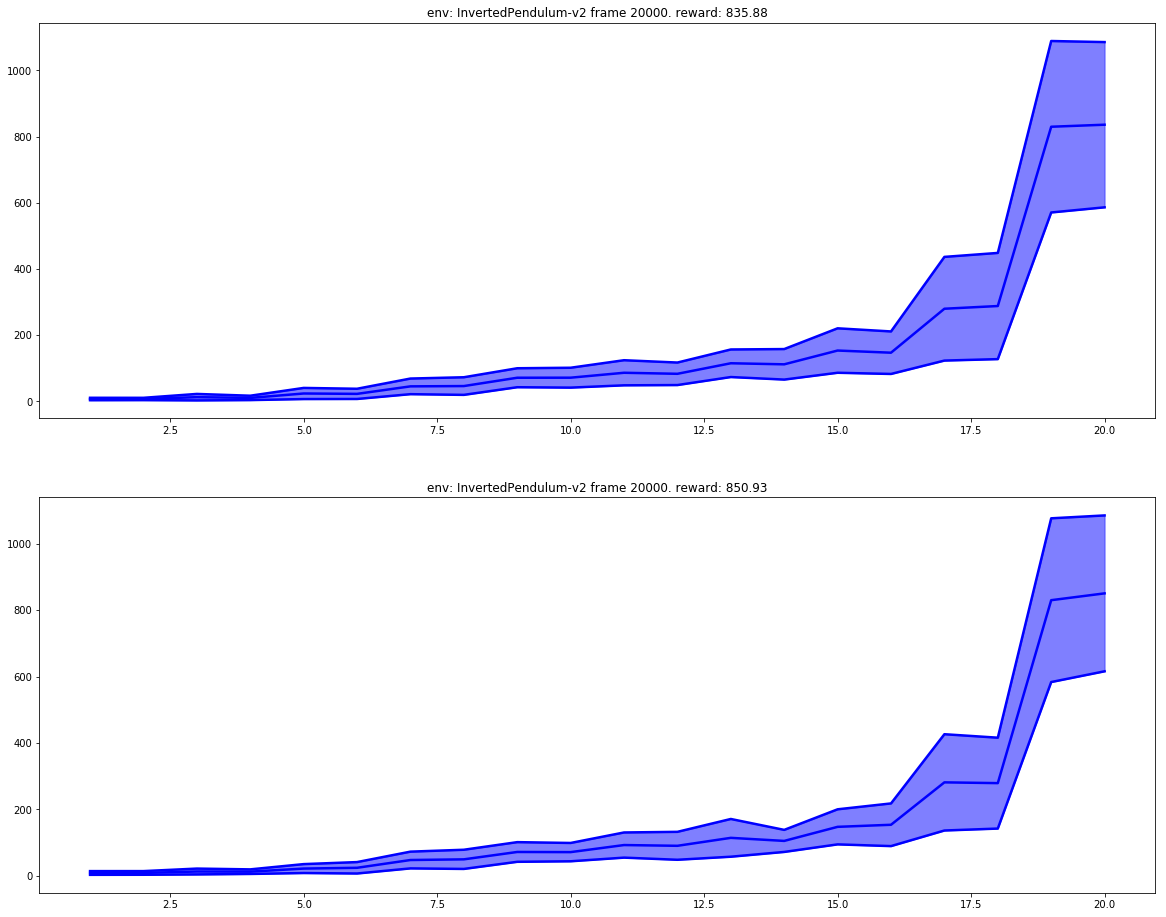

In [ ]:
state = envs.reset()
early_stop = False

while frame_idx < max_frames and not early_stop:

    log_probs = []
    values    = []
    states    = []
    actions   = []
    rewards   = []
    masks     = []
    entropy = 0
    counter = 0

    for _ in range(num_steps):
        state = torch.FloatTensor(state).to(device)
        dist, value = model(state)

        action = dist.sample()
        next_state, reward, done, _ = envs.step(action.cpu().numpy())

        log_prob = dist.log_prob(action)
        entropy += dist.entropy().mean()
        
        log_probs.append(log_prob)
        values.append(value)
        rewards.append(torch.FloatTensor(reward).unsqueeze(1).to(device))
        masks.append(torch.FloatTensor(1 - done).unsqueeze(1).to(device))
        
        states.append(state)
        actions.append(action)
        
        state = next_state
        frame_idx += 1
        
# def test_rollouts(test_envs, test_itrs, ):
#     avg_rew = []
#     std = []
#     for env in test_envs:
#         env_rewards = ([test_env(env) for _ in range(test_itrs)])
#         avg_rew.append(np.mean(env_rewards))
#         std.append(np.std(env_rewards))
#     return avg_rew, std
        
# def test_env(test_env, vis=False):
#     state = test_env.reset()
#     if vis: test_env.render()
#     done = False
#     total_reward = 0
#     while not done:
#         state = torch.FloatTensor(state).unsqueeze(0).to(device)
#         dist, _ = model(state)
#         next_state, reward, done, _ = test_env.step(dist.sample().cpu().numpy()[0])
#         state = next_state
#         if vis: test_env.render()
#         total_reward += reward
#     return total_reward        
            
            
        if frame_idx % 1000 == 0:
            #avg_rew, std = test_rollouts(test_envs, test_itrs):
            
            avg_rew = []
            std = []
            
            for env in test_envs:
                env_rewards = ([test_env(env) for _ in range(test_itrs)])
                avg_rew.append(np.mean(env_rewards))
                std.append(np.std(env_rewards))
                
            test_avg_rewards.append(avg_rew)
            test_stds.append(std)
            
            plot(frame_idx, test_avg_rewards, test_stds, test_env_names)
            if avg_rew[0] > threshold_reward and EARLY_STOPPING: #avg_rew[0] is testing on the non edited environment
                early_stop = True

    next_state = torch.FloatTensor(next_state).to(device)
    _, next_value = model(next_state)
    returns = compute_gae(next_value, rewards, masks, values)

    returns   = torch.cat(returns).detach()
    log_probs = torch.cat(log_probs).detach()
    values    = torch.cat(values).detach()
    states    = torch.cat(states)
    actions   = torch.cat(actions)
    advantage = returns - values
    
    ppo_update(ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantage)

<h1>Saving trajectories for GAIL</h1>

In [ ]:
# from itertools import count

# max_expert_num = 50000
# num_steps = 0
# expert_traj = []

# for i_episode in count():
#     state = env.reset()
#     done = False
#     total_reward = 0
    
#     while not done:
#         state = torch.FloatTensor(state).unsqueeze(0).to(device)
#         dist, _ = model(state)
#         action = dist.sample().cpu().numpy()[0]
#         next_state, reward, done, _ = env.step(action)
#         state = next_state
#         total_reward += reward
#         expert_traj.append(np.hstack([state, action]))
#         num_steps += 1
    
#     print("episode:", i_episode, "reward:", total_reward)
    
#     if num_steps >= max_expert_num:
#         break
        
# expert_traj = np.stack(expert_traj)
# print()
# print(expert_traj.shape)
# print()
# np.save("expert_traj.npy", expert_traj)